## Bayesian hierarchical model to estimate treatment effects

Here, I attempt to account for the simultaneous impact of sensor feedback on lift rates and safety by:

Model 1: y = a + b1Treatment + b2LiftRate-t + error
b1 = p + qLiftRate-t + error


Model 2: y = a + b1Treatment + b2estimate(LiftRate-t) + error
b1 = p + qLiftRate-t + error
estimated(LiftRate-t) = m + nLiftRate-t-1

Model 3: 
y = a + b1Treatment + b2LiftRate-t + error
b2 = p + qTreatment + mLift-Rate-t-1 error



In [4]:
import pymc as pm
import pandas as pd
import itertools as itt
import arviz as az
import graphviz
import numpy as np
import importlib as imp
import matplotlib.pyplot as plt

In [5]:
melted_df = pd.read_csv("melted_data.csv")
df = pd.read_csv("data.csv")

In [7]:
melted_full_obs = melted_df.dropna().copy()

melted_full_obs['Treatment'] = melted_full_obs['Haptic Group']
melted_full_obs.loc[melted_df['Stage'] == 'Baseline', 'Treatment'] = 'Baseline'
melted_full_obs['TreatmentIDX'] = pd.Categorical(melted_full_obs['Treatment']).codes

melted_full_obs['idx'] = pd.Categorical(melted_full_obs['ID']).codes

## Model 1 - baseline, simple regression linking treatment and lift rate

In [14]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0]),
    "group": melted_full_obs['TreatmentIDX'].unique(),
}


with pm.Model(coords = coords) as base_model:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    tr_idx = pm.Data("t_idx", melted_full_obs['TreatmentIDX'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)
    
    ##Setting intercept
    a = pm.Normal("alpha", 0, 1000)
    
    #Treatment effect
    mu_b = pm.Normal("mu_b", 0, 100)
    b = pm.Normal("beta", mu_b, 100, dims="group")
    
    ##Lift rate direct effect
    c = pm.Normal("gamma", 0, 100)
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = a + b[tr_idx] + c * rates
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

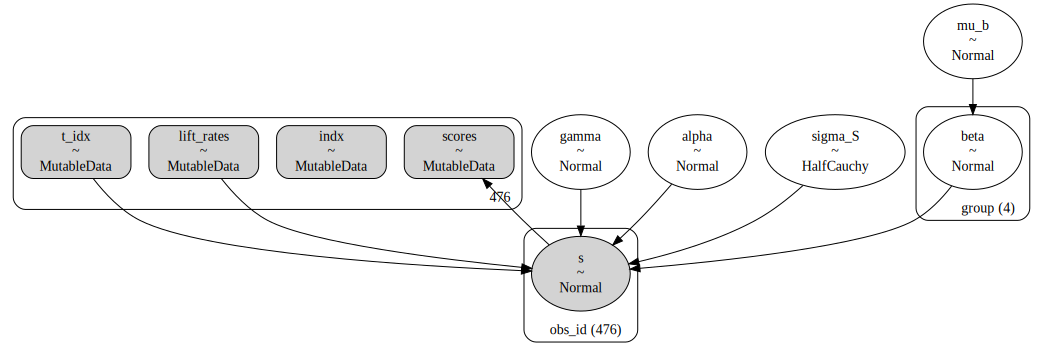

In [15]:
pm.model_to_graphviz(base_model)

In [16]:
with base_model:
    base_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, mu_b, beta, gamma, sigma_S]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 228 seconds.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 747 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5738, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for relia

In [17]:
results = az.summary(base_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S'])
results

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,116.793,119.639,-70.961,255.328,37.992,29.260,11.0,293.0,1.28
beta[3],-36.948,119.658,-175.065,151.041,38.009,27.710,11.0,275.0,1.28
beta[0],-38.026,119.646,-176.618,149.757,38.007,27.708,11.0,285.0,1.28
beta[1],-38.470,119.666,-176.865,149.780,38.012,27.712,11.0,271.0,1.28
beta[2],-38.213,119.653,-176.757,149.703,38.006,27.707,11.0,257.0,1.28
gamma,-0.110,0.008,-0.124,-0.098,0.000,0.000,1234.0,979.0,1.40
sigma_S,4.703,0.158,4.485,4.951,0.039,0.028,17.0,1340.0,1.17


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>]], dtype=object)

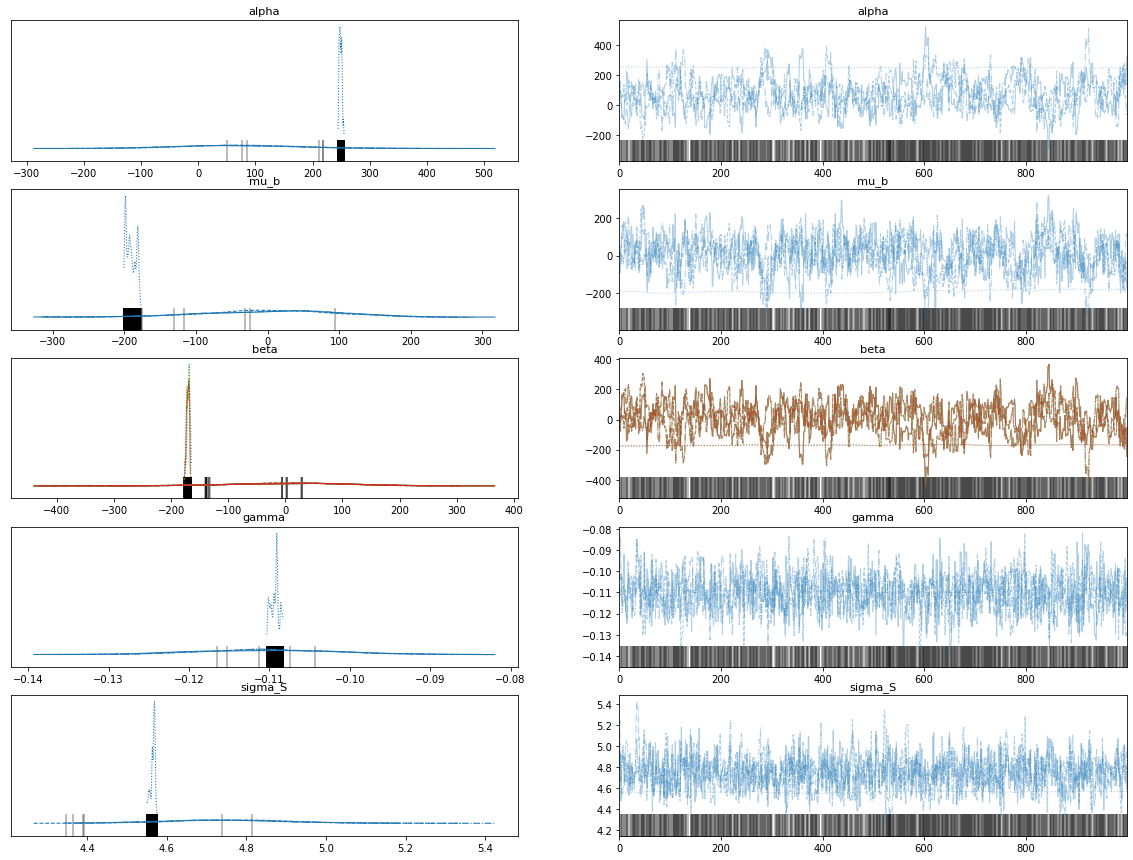

In [18]:
az.plot_trace(base_trace, figsize=(20,15))

## Model 2 - add individual random effects

In [156]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as random_effects_model:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values)
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, dims="worker")
    α = pm.Normal("alpha", 0, 1000)
    a = pm.Deterministic("a", α + f_a[idx] * sigma_a, dims="obs_id")
       
    #Treatment effect
    b = pm.Normal("beta", 0, 100)
    
    ##Lift rate direct effect
    c = pm.Normal("gamma", 0, 100)
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + b * treatments + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

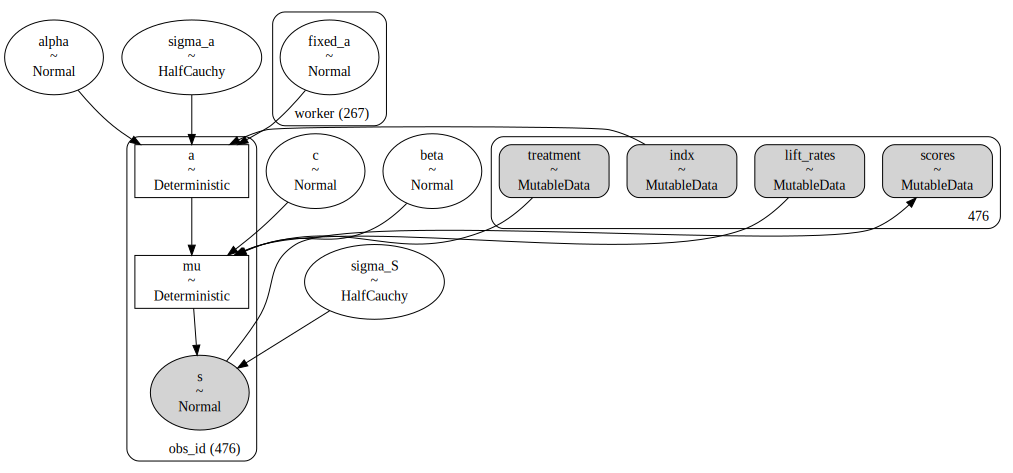

In [157]:
pm.model_to_graphviz(random_effects_model)

In [158]:
with random_effects_model:
    random_effects_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, beta, c, sigma_S]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.
There were 108 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7199, but should be close to 0.8. Try to increase the number of tuning steps.


In [165]:
az.summary(random_effects_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_a'])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.785,0.902,77.251,80.256,0.023,0.017,1495.0,1051.0,1.00
beta,0.366,0.271,-0.088,0.794,0.004,0.003,3728.0,1684.0,1.00
c,-0.112,0.008,-0.125,-0.098,0.000,0.000,1195.0,996.0,1.01
sigma_S,2.658,0.130,2.457,2.876,0.004,0.003,783.0,725.0,1.00
sigma_a,3.979,0.219,3.605,4.319,0.007,0.005,1058.0,1631.0,1.00


array([[<AxesSubplot:title={'center':'fixed_a'}>,
        <AxesSubplot:title={'center':'fixed_a'}>],
       [<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'c'}>,
        <AxesSubplot:title={'center':'c'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>]], dtype=object)

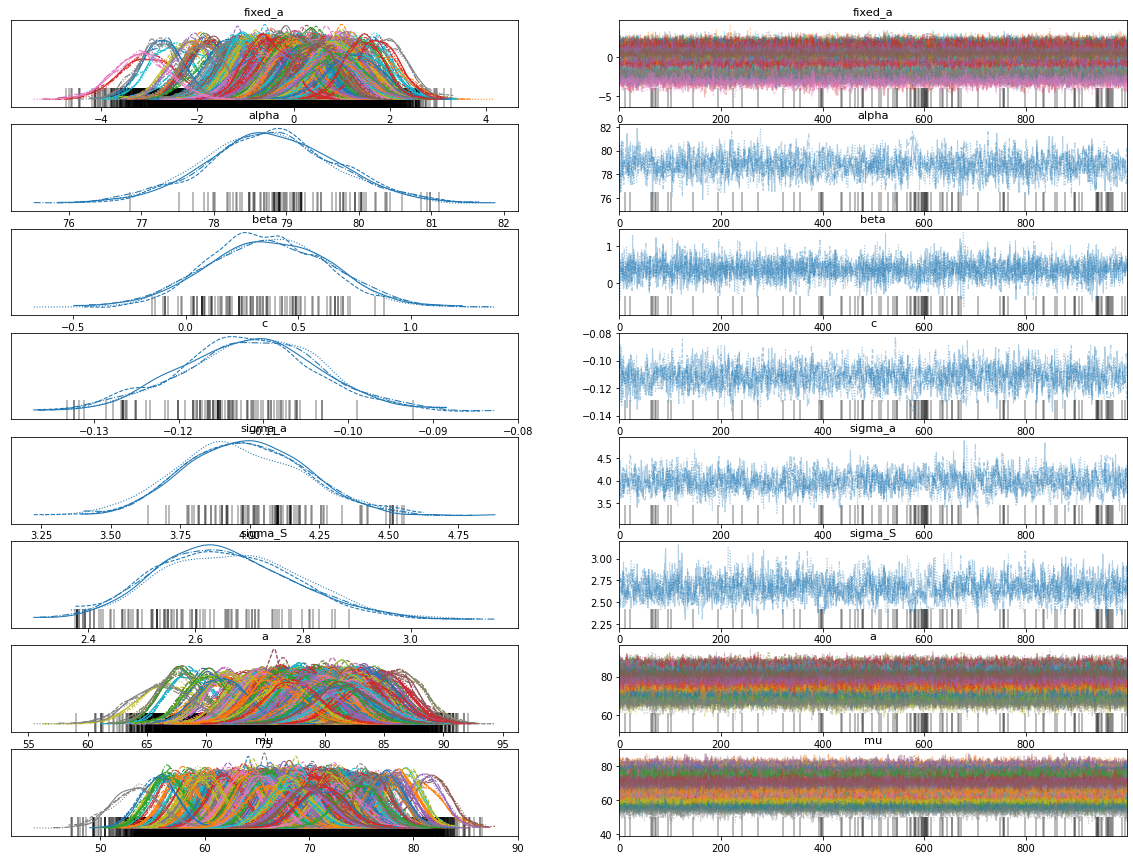

In [161]:
az.plot_trace(random_effects_trace, figsize=(20,15))

## Model 3 - adding random effects to the lift-rate relationship

In [185]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as model3:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, dims="worker")
    α = pm.Normal("alpha", 0, 1000)
    a = pm.Deterministic("a", α + f_a[idx] * sigma_a, dims="obs_id")
       
    #Treatment effect        
    b = pm.Normal("beta", 0, 1000)    
    
    ##Lift rate direct effect
    γ = pm.Normal("gamma", 0, 100)
    sigma_c = pm.HalfCauchy("sigma_c", 3)
    f_c = pm.Normal("fixed_c", 0, 1, dims="worker")    
    c = pm.Deterministic("c", γ + f_c[idx] * sigma_c, dims="obs_id")
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + b * treatments + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

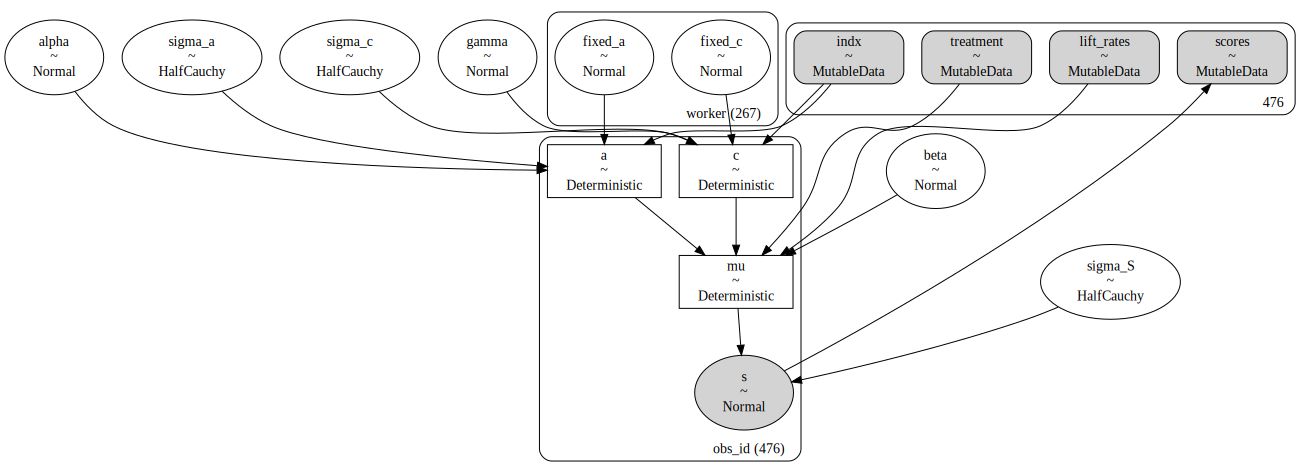

In [186]:
pm.model_to_graphviz(model3)

In [187]:
with model3:
    model3_trace = pm.sample(tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, beta, gamma, sigma_c, fixed_c, sigma_S]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 36 seconds.
There were 28 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [188]:
az.summary(model3_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_a', 'sigma_c'])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.763,0.870,77.395,80.233,0.022,0.015,1585.0,2256.0,1.01
beta,0.368,0.268,-0.066,0.818,0.004,0.003,4208.0,2572.0,1.00
gamma,-0.111,0.008,-0.124,-0.097,0.000,0.000,1559.0,1997.0,1.01
sigma_S,2.653,0.133,2.438,2.864,0.004,0.003,1194.0,2318.0,1.00
sigma_a,3.961,0.240,3.577,4.366,0.010,0.007,566.0,840.0,1.01
sigma_c,0.005,0.004,0.000,0.011,0.000,0.000,191.0,317.0,1.02


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>]], dtype=object)

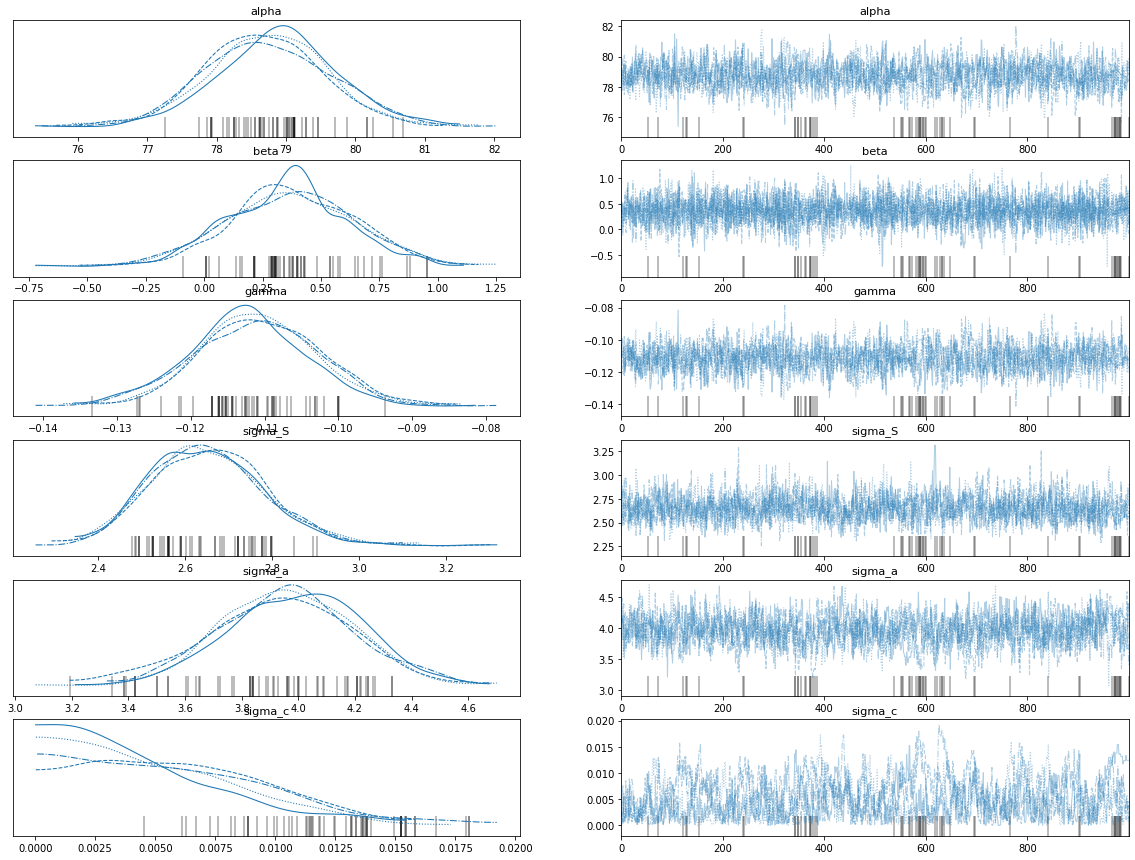

In [191]:
az.plot_trace(model3_trace, figsize=(20,15), var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_a', 'sigma_c'])

## Model 4 - what about no random effects in the intercept instead?

In [192]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as model4:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)
    
    ##Setting intercepts    
    a = pm.Normal("alpha", 0, 1000)    
       
    #Treatment effect        
    b = pm.Normal("beta", 0, 1000)    
    
    ##Lift rate direct effect
    γ = pm.Normal("gamma", 0, 100)
    sigma_c = pm.HalfCauchy("sigma_c", 3)
    f_c = pm.Normal("fixed_c", 0, 1, dims="worker")    
    c = pm.Deterministic("c", γ + f_c[idx] * sigma_c, dims="obs_id")
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + b * treatments + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

In [193]:
with model4:
    model4_trace = pm.sample(tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, sigma_c, fixed_c, sigma_S]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 23 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


In [195]:
az.summary(model4_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_c'])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.284,0.788,76.987,79.580,0.023,0.016,1159.0,1834.0,1.00
beta,0.425,0.324,-0.108,0.945,0.006,0.004,3090.0,2688.0,1.00
gamma,-0.107,0.008,-0.121,-0.094,0.000,0.000,1015.0,1808.0,1.00
sigma_S,3.397,0.180,3.105,3.687,0.007,0.005,587.0,1007.0,1.01
sigma_c,0.035,0.003,0.030,0.040,0.000,0.000,514.0,766.0,1.01


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>]], dtype=object)

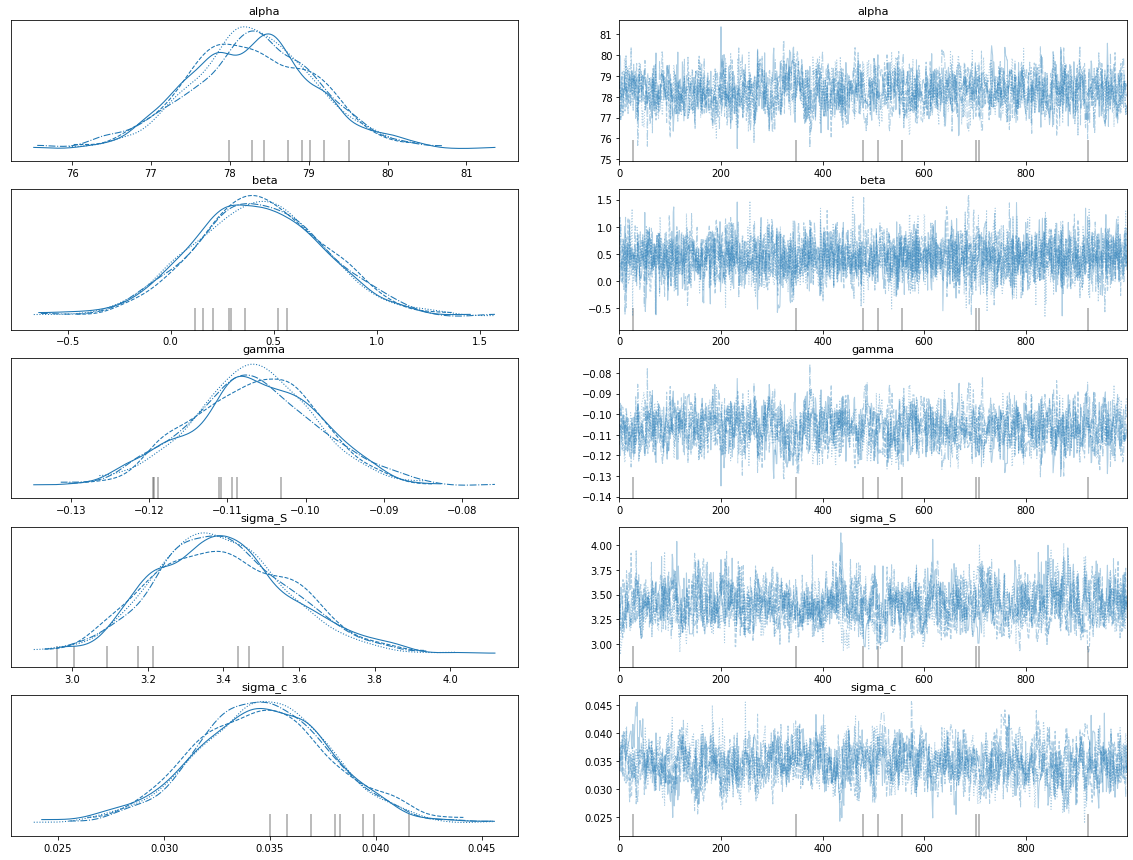

In [197]:
az.plot_trace(model4_trace, figsize=(20,15), var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_c'])

## Let's use both random effects and add additional impact of treatment to liftrate coefficient impact

In [202]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0])
}

with pm.Model(coords = coords) as model5:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    treatments = pm.Data("treatment", melted_full_obs['Treatment'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, dims="worker")
    α = pm.Normal("alpha", 0, 1000)
    a = pm.Deterministic("a", α + f_a[idx] * sigma_a, dims="obs_id")
       
    #Direct Treatment effect        
    b = pm.Normal("beta", 0, 1000)    
    
    
    
    ##Lift rate direct effect
    γ = pm.Normal("gamma", 0, 100)
    sigma_c = pm.HalfCauchy("sigma_c", 3)
    f_c = pm.Normal("fixed_c", 0, 1, dims="worker")        
    dir_c = pm.Deterministic("dir_c", γ + f_c[idx] * sigma_c, dims="obs_id")
    
    ##Add treatment influence
    z = pm.Normal("z", 0, 100)
    c = pm.Deterministic("c", dir_c + z * treatments, dims="obs_id")    
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + b * treatments + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

In [203]:
with model5:
    model5_trace = pm.sample(tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, beta, gamma, sigma_c, fixed_c, z, sigma_S]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 45 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [204]:
az.summary(model5_trace, hdi_prob=0.90, var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_c', "z", "sigma_a"])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.631,1.030,76.970,80.352,0.031,0.022,1126.0,1578.0,1.00
beta,0.491,1.038,-1.183,2.176,0.027,0.019,1482.0,1878.0,1.00
gamma,-0.110,0.010,-0.126,-0.094,0.000,0.000,1079.0,1499.0,1.01
sigma_S,2.655,0.134,2.420,2.857,0.004,0.003,1222.0,2021.0,1.00
sigma_c,0.006,0.005,0.000,0.012,0.000,0.000,204.0,177.0,1.02
z,-0.001,0.010,-0.018,0.015,0.000,0.000,1612.0,1954.0,1.00
sigma_a,3.936,0.246,3.543,4.316,0.010,0.007,705.0,727.0,1.00


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>]], dtype=object)

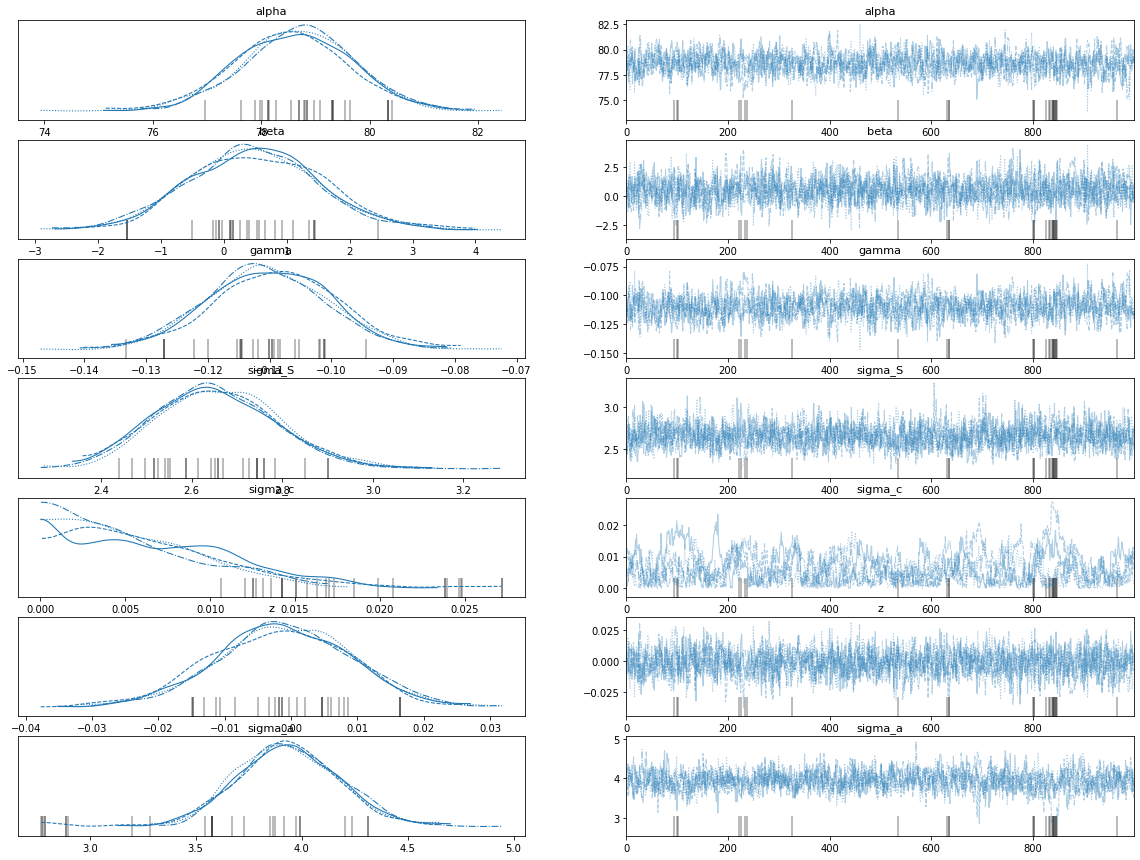

In [205]:
az.plot_trace(model5_trace, figsize=(20,15), var_names=['alpha', 'beta', 'gamma', 'sigma_S', 'sigma_c', "z", "sigma_a"])

## Final attempt - what about no direct impact?

In [19]:
coords = {
    "worker": melted_full_obs['idx'].unique(),
    "obs_id": np.arange(melted_full_obs.shape[0]),
    "group": melted_full_obs['TreatmentIDX'].unique(),
}


with pm.Model(coords = coords) as final_model:
    
    #register the data
    scores = pm.Data("scores", melted_full_obs['Average Safety Score'].values, mutable=True)    
    rates = pm.Data("lift_rates", melted_full_obs['Average Lift Rate'].values, mutable=True)    
    tr_idx = pm.Data("t_idx", melted_full_obs['TreatmentIDX'].values, mutable=True) 
    idx = pm.Data("indx", melted_full_obs['idx'].values, mutable=True)   
    
    ##Setting intercepts
    sigma_a = pm.HalfCauchy("sigma_a", 3)
    f_a = pm.Normal("fixed_a", 0, 1, dims="worker")
    α = pm.Normal("alpha", 0, 1000)
    a = pm.Deterministic("a", α + f_a[idx] * sigma_a, dims="obs_id")    
    
    ##Lift rate direct effect
    γ = pm.Normal("gamma", 0, 100)
    sigma_c = pm.HalfCauchy("sigma_c", 3)
    f_c = pm.Normal("fixed_c", 0, 1, dims="worker")        
    dir_c = pm.Deterministic("dir_c", γ + f_c[idx] * sigma_c, dims="obs_id")
    
    ##Add treatment influence
    z = pm.Normal("z", 0, 100, dims="group")
    c = pm.Deterministic("c", dir_c + z[tr_idx], dims="obs_id")    
    
    ## Model errors
    sigma_S = pm.HalfCauchy("sigma_S", 3)    
    mu = pm.Deterministic("mu", a + c * rates, dims="obs_id")
    pm.Normal("s", mu, sigma_S, observed=scores, dims="obs_id")

In [20]:
with final_model:
    final_model_trace = pm.sample(tune=2_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/aurimas/apps/anaconda3/envs/strongarm/lib/python3.10/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, fixed_a, alpha, gamma, sigma_c, fixed_c, z, sigma_S]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 641 seconds.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.5047, but should be close to 0.8. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.4145, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effect

In [21]:
az.summary(final_model_trace, hdi_prob=0.90, var_names=['alpha', 'gamma', 'sigma_S', 'sigma_c', "z", "sigma_a"])

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,78.629,0.791,77.922,80.251,0.222,0.161,12.0,54.0,1.84
gamma,-0.478,3.931,-6.873,2.587,1.724,1.295,6.0,16.0,2.48
sigma_S,2.558,0.159,2.352,2.788,0.063,0.047,6.0,27.0,1.71
sigma_c,0.003,0.003,0.000,0.006,0.001,0.001,7.0,33.0,1.56
z[3],0.376,3.928,-2.665,6.788,1.722,1.293,6.0,16.0,2.45
z[0],0.374,3.929,-2.667,6.792,1.722,1.293,6.0,16.0,2.46
z[1],0.367,3.928,-2.676,6.782,1.722,1.293,6.0,16.0,2.45
z[2],0.368,3.929,-2.674,6.785,1.722,1.293,6.0,16.0,2.46
sigma_a,4.106,0.266,3.727,4.456,0.101,0.076,8.0,33.0,1.86


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'gamma'}>,
        <AxesSubplot:title={'center':'gamma'}>],
       [<AxesSubplot:title={'center':'sigma_S'}>,
        <AxesSubplot:title={'center':'sigma_S'}>],
       [<AxesSubplot:title={'center':'sigma_c'}>,
        <AxesSubplot:title={'center':'sigma_c'}>],
       [<AxesSubplot:title={'center':'z'}>,
        <AxesSubplot:title={'center':'z'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>]], dtype=object)

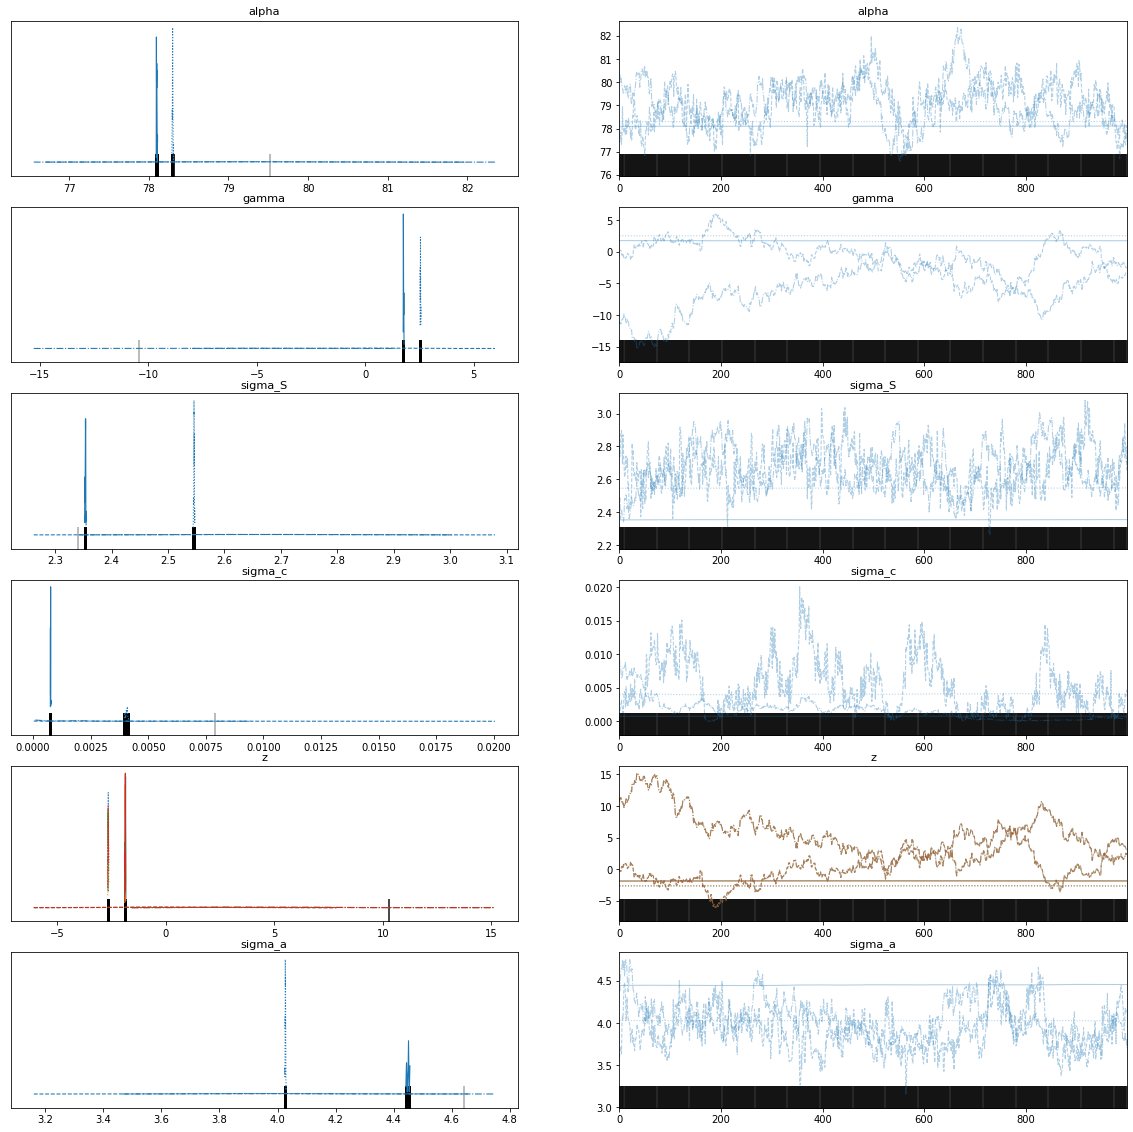

In [23]:
az.plot_trace(final_model_trace, figsize=(20,20), var_names=['alpha', 'gamma', 'sigma_S', 'sigma_c', "z", "sigma_a"])